In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import quandl
import pandas_datareader.data as web

from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
    USLaborDay, USThanksgivingDay


class USTradingCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('NewYearsDay', month=1, day=1, observance=nearest_workday),
        USMartinLutherKingJr,
        USPresidentsDay,
        GoodFriday,
        USMemorialDay,
        Holiday('USIndependenceDay', month=7, day=4, observance=nearest_workday),
        USLaborDay,
        USThanksgivingDay,
        Holiday('Christmas', month=12, day=25, observance=nearest_workday)]

A popular use with regression is to predict stock prices. This is done because we are considering the fluidity of price over time, and attempting to forecast the next fluid price in the future using a continuous dataset.

Since regression is so popularly used with stock prices, we can start there with an example. To begin, we need data. Sometimes the data is easy to acquire, and sometimes you have to go out and scrape it together. In our case, we're able to at least start with simple stock price and volume information from Quandl. To begin, we'll start with data that grabs the stock price for Alphabet (previously Google), with the ticker of `GOOGL`:

The WIKI is not up-to-date. Another way to get latest stock prices is using `pandas_datareader`:

In [3]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.now()

ticker = 'GOOGL'
df = web.DataReader(ticker, 'yahoo', start, end)
df = df.loc[df.index < '2019-01-01']

df = df[['Open',  'High',  'Low',  'Close', 'Volume']]
df['HL_PCT'] = (df['High'] - df['Low']) / df['Low'] * 100.0
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
df = df[['Close', 'HL_PCT', 'PCT_change', 'Volume']]

- HL_PCT: Percent spread based on the closing price, which is our crude measure of volatility.
- PCT_change: Daily percent change

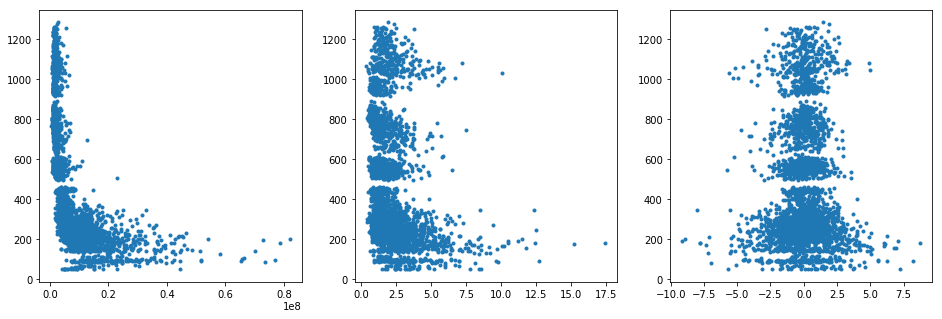

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
axs[0].plot(df.Volume,df.Close,marker='.',ls='none')

axs[1].plot(df.HL_PCT,df.Close,marker='.',ls='none')

axs[2].plot(df.PCT_change,df.Close,marker='.',ls='none')

plt.show()

In [5]:
#forecast_col = 'Adj. Close'
forecast_col = 'Close'

In [6]:
df.fillna(value=-99999, inplace=True)

shift_frc = 0.01
forecast_out = int(math.ceil(shift_frc * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

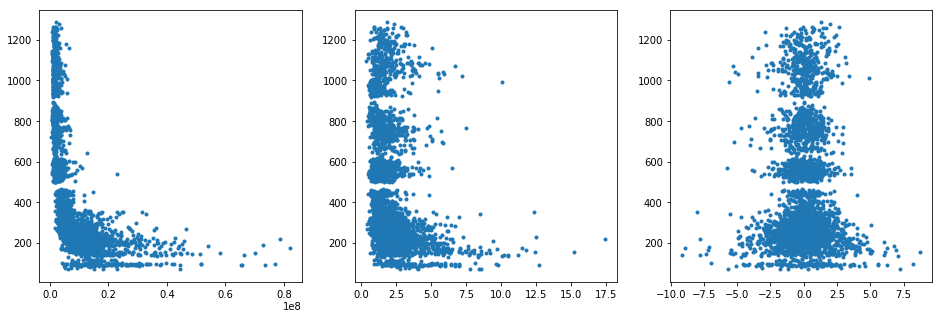

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
axs[0].plot(df.Volume,df.label,marker='.',ls='none')

axs[1].plot(df.HL_PCT,df.label,marker='.',ls='none')

axs[2].plot(df.PCT_change,df.label,marker='.',ls='none')

plt.show()

It is a typical standard with machine learning in code to define X (capital x), as the features, and y (lowercase y) as the label that corresponds to the features. As such, we can define our features like so:

In [8]:
X = np.array(df.drop(['label'], 1))

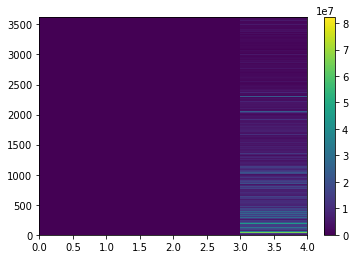

In [9]:
plt.pcolormesh(X)
plt.colorbar()

Above, what we've done, is defined X (features), as our entire dataframe EXCEPT for the label column, converted to a numpy array. We do this using the `.drop` method that can be applied to dataframes, which returns a new dataframe. Next, we define our y variable, which is our label, as simply the label column of the dataframe, converted to a numpy array.

We could leave it at this, and move on to training and testing, but we're going to do some pre-processing. Generally, you want your features in machine learning to be in a range of -1 to 1. This may do nothing, but it usually speeds up processing and can also help with accuracy. Because this range is so popularly used, it is included in the preprocessing module of Scikit-Learn. To utilize this, you can apply `preprocessing.scale` to your X variable:

In [10]:
X = preprocessing.scale(X)

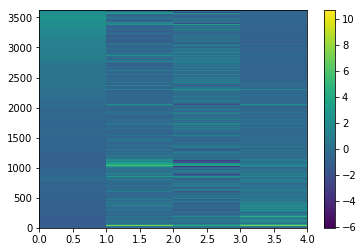

In [11]:
plt.pcolormesh(X)
plt.colorbar()

Now, we're going to define `X_lately` which contains the most recent features This is used to predict against. We don not include the most recent rows in X, so we redefine X to exclude the last rows set by forecast_out.

In [12]:
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

We'll drop any rows with NaNs (this is at the end of the dataframe for the label column)

In [13]:
# For same-day prediction
df.dropna(inplace=True)

 Now we can define our labels (which should have the same length as our features)

In [14]:
# For future prediction
#y = np.array(df.dropna()['label'])

# For same-day prediction
y = np.array(df['label'])

Now comes the training and testing. The way this works is you take, for example, 75% of your data, and use this to train the machine learning classifier. Then you take the remaining 25% of your data, and test the classifier. Since this is your sample data, you should have the features and known labels. Thus, if you test on the last 25% of your data, you can get a sort of accuracy and reliability, often called the confidence score. There are many ways to do this, but, probably the best way is using the build in `cross_validation` provided, since this also shuffles your data for you. The code to do this:

In [15]:
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

The return here is the training set of features, testing set of features, training set of labels, and testing set of labels. Now, we're ready to define our classifier. There are many classifiers in general available through Scikit-Learn, and even a few specifically for regression.

In [16]:
# Linear Regression
clf = LinearRegression(n_jobs=-1)

# Support Vector Regression
#clf = svm.SVR()

**Note**:  With `LinearRegression`, you can specify exactly how many threads you'll want. If you put in -1 for the value, then the algorithm will use all available threads.

Once you have defined the classifer, you're ready to train it. With Scikit-Learn (sklearn), you train with `.fit`.

In [17]:
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Our classifier is now trained. Now we can test it.

In [18]:
accuracy = clf.score(X_test, y_test)

In [19]:
print(accuracy)

0.9775832776837237


There is a parameter to `svm.SVR` for example which is *kernel*. Think of a *kernel* like a transformation against your data. It's a way to grossly, and I mean grossly, simplify your data. This makes processing go much faster. In the case of `svm.SVR`, the default is 'rbf', which is a type of *kernel*. You have a few other choices though. Check the documentation, you have 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable. Again, just like the suggestion to try the various ML algorithms that can do what you want, try the kernels. Let's do a few:

As we can see, the linear kernel performed the best, closely by rbf, then poly, then sigmoid was clearly just goofing off and definitely needs to be kicked from the team. I will stress that creating a linear model with say >95% accuracy is not that great. I certainly wouldn't trade stocks on it. There are still many issues to consider, especially with different companies that have different price trajectories over time. Google really is very linear: Up and to the right. Many companies aren't, so keep this in mind.

Now, to forecast out, we need some data. We decided that we're forecasting out 1% of the data, thus we will want to, or at least *can* generate forecasts for each of the final 1% of the dataset. So when can we do this? When would we identify that data? We could call it now, but consider the data we're trying to forecast is not scaled like the training data was. Okay, so then what? Do we just do `preprocessing.scale()` against the last 1%? The scale method scales based on all of the known data that is fed into it. Ideally, you would scale both the training, testing, AND forecast/predicting data all together. Is this always possible or reasonable? No. If you can do it, you should, however. In our case, right now, we can do it. Our data is small enough and the processing time is low enough, so we'll preprocess and scale the data all at once.

In many cases, you won't be able to do this. Imagine if you were using gigabytes of data to train a classifier. It may take days to train your classifier, you wouldn't want to be doing this every single time you wanted to make a prediction. Thus, you may need to either NOT scale anything, or you may scale the data separately. As usual, you will want to test both options and see which is best in your specific case.

In [20]:
forecast_set = clf.predict(X_lately)

The forecast_set is an array of forecasts, showing that not only could you just seek out a single prediction, but you can seek out many at once. To see what we have thus far:

In [21]:
print(forecast_set, accuracy, forecast_out)

[1079.042978   1116.43886385 1105.44057378 1087.57432031 1059.08797466
 1058.41943145 1065.01277242 1078.14412989 1079.47352414 1035.54289601
 1037.46710295 1055.40677624 1042.63083263 1066.9258602  1063.0698482
 1096.10512358 1105.40157869 1118.39306687 1126.85432708 1069.85331142
 1084.56858257 1054.27588778 1062.65461202 1072.79664285 1084.99000208
 1084.23243316 1062.64579982 1032.96840154 1052.31818664 1040.44021689
 1031.02492878  996.30132808  993.23448519 1050.21722505 1057.99898463
 1057.85886081 1054.8829748 ] 0.9775832776837237 37


So these are our forecasts out. Now what? Well, you are basically done, but we can work on visualizing this information. So stock prices are daily, for 5 days, and then there are no prices on the weekends. I recognize this fact, but we're going to keep things simple, and plot each forecast as if it is simply 1 day out. If you want to try to work in the weekend gaps (don't forget holidays) go for it, but we'll keep it simple.

First, we're going to add a new column to our dataframe, the forecast column

In [22]:
df['Forecast'] = np.nan

We set the value as a NaN first, but we'll populate some shortly. We said we're going to just start the forecasts as tomorrow (recall that we predict 10% out into the future, and we saved that last 10% of our data to do this, thus, we can begin immediately predicting since -10% has data that we can predict 10% out and be the next prediction). We need to first grab the last day in the dataframe, and begin assigning each new forecast to a new day. We will start that like so:

In [23]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400

# Conversion sets back time to 5 hours. So we add one day to get to the actual starting point
next_unix = last_unix + one_day

In [24]:
cal = USTradingCalendar()
holidays = cal.holidays(start=end.replace(month=2,day=1,hour=0,minute=0,second=0,microsecond=0), 
                        end=end.replace(hour=0,minute=0,second=0,microsecond=0) \
                        + datetime.timedelta(days=forecast_out+10)).to_pydatetime()

In [25]:
for val in forecast_set:
    next_unix += one_day
    next_date = datetime.datetime.fromtimestamp(next_unix).replace(hour=0)
    while next_date.weekday()>4 or next_date.replace(hour=0) in holidays:
        #print(next_date.strftime('%b %d %Y'), 'is a weekend or holiday')
        next_unix += one_day
        next_date = datetime.datetime.fromtimestamp(next_unix).replace(hour=0)
    #print(next_date)
    df.loc[next_date] = [np.nan for col in range(len(df.columns)-1)]+[val]

In [26]:
df.tail()

,Close,HL_PCT,PCT_change,Volume,label,Forecast
Date,,,,,,
2018-12-20,NaN,NaN,NaN,NaN,NaN,993.234485
2018-12-21,NaN,NaN,NaN,NaN,NaN,1050.217225
2018-12-24,NaN,NaN,NaN,NaN,NaN,1057.998985
2018-12-25,NaN,NaN,NaN,NaN,NaN,1057.858861
2018-12-26,NaN,NaN,NaN,NaN,NaN,1054.882975


In [27]:
latest = web.DataReader(ticker, 'yahoo', start, end)

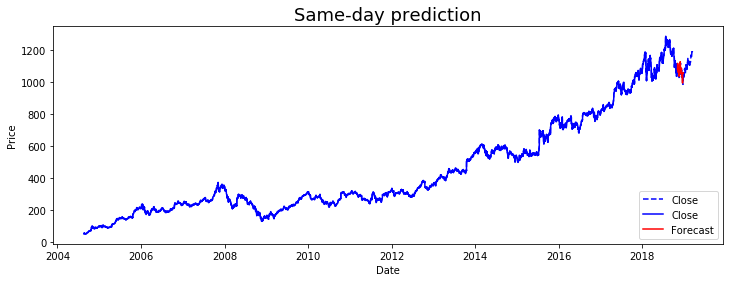

In [29]:
fig = plt.figure(figsize=(12,4))

plt.plot(latest.index,latest['Close'],c='b',ls='--')
plt.plot(df.index,df['Close'],c='b')
plt.plot(df.index,df['Forecast'],c='r')
#plt.plot(df.index,df['label'],color='purple',ls='-')#,marker='.')

plt.legend(loc=4)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Same-day prediction',fontsize=18)
plt.show()

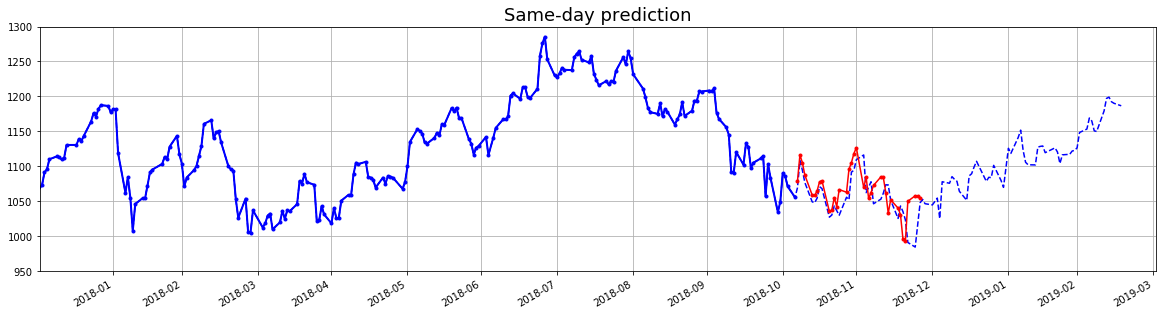

In [30]:
fig = plt.figure(figsize=(20,5))

plt.plot(latest.index,latest['Close'],c='b',ls='--')
plt.plot(df.drop(['Forecast'], 1).dropna().index,df.drop(['Forecast'], 1).dropna()['Close'],c='b',marker='.',lw=2)
plt.plot(df.index,df['Close'],c='b',lw=1)
plt.plot(df.index,df['Forecast'],c='r',marker='.')
#plt.plot(df.index,df['label'],color='purple',ls=':',marker='.')

plt.ylim([950,1300])
plt.xlim(['2018-01-01','2019-04-01'])
fig.autofmt_xdate()

plt.xticks(pd.date_range('2018-01-01','2019-04-01',freq='1M'))

plt.grid()
plt.title('Same-day prediction',fontsize=18)
plt.show()

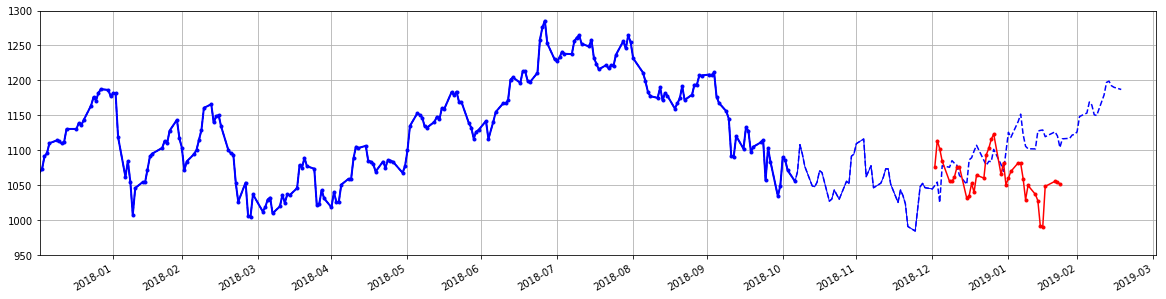